# Optimizing a power system economic dispatch (ED)

Economic Dispatch (ED) in power systems involves operating generation power plants to produce electricity at the lowest possible cost while meeting load demand, subject to the operational constraints of generation and transmission facilities.

In this notebook, we use PREP-SHOT to model a simplified economic dispatch for the Thailand power system. For this example, we treat the entire Thailand power system as a single node, with imported electricity considered as variable renewable energy. We exclude specific details about generation plants other than those in Thailand. The purpose is to demonstrate how to use PREP-SHOT for a single-year, single-node simulation. You can also set up a null initial power system and allow for overnight single-year investments.

Let's get started!

## The data

### Historical power demand data

Coming soon!

### Power plant data

Coming soon!

### Hydropower plant data

Coming soon!

### Inflow of hydropower plant

Coming soon!

### Plant capacities and limits

Coming soon!

### Costs



## Run PREP-SHOT

In [1]:
# This cell may spend 2-5 minutes depending on the device
import subprocess
# Copy config files to the run directory & Run model
commands = (
    'cp -f config.json ../../config.json && '
    'cp -f params.json ../../params.json && '
    'cd ../../ && '
    'python run.py'
)
log_ = subprocess.run(commands, shell=True, capture_output=True, text=True)


## Optimal power generation mix

In [2]:
import sys
sys.path.append('../../')

import xarray as xr
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from prepshot.load_data import load_excel_data, load_json

In [3]:
params = load_json('params.json')
inputs = {}
load_excel_data(
    './input',
    {'demand':params['demand'],
    'capacity_factor': params['capacity_factor'],
    'technology_portfolio': params['technology_portfolio']},
    inputs
)
load = pd.DataFrame.from_dict(
    inputs['demand'], orient='index', columns=['Value']
)
load.index = pd.MultiIndex.from_tuples(
    load.index, names=['Country', 'Year', 'Month', 'Day']
)
load.index = pd.date_range('20230101', periods=len(load), freq='H')
capacity_factor = pd.DataFrame.from_dict( 
    inputs['capacity_factor'], orient='index', columns=['Value']
)
capacity_factor.index = pd.MultiIndex.from_tuples(
    capacity_factor.index, names=['Tech', 'Country', 'Year', 'Month', 'Day']
)
capacity_factor = capacity_factor.unstack(level=0).droplevel(0, axis=1)
cap = inputs['technology_portfolio']
power_renewable = 0
for p in capacity_factor.columns:
    power_renewable += capacity_factor[p].values * cap[p, 'Thailand']
# MW to GW

In [4]:
filename = "./output/baseline.nc"
ds = xr.open_dataset(filename)
ds.close()

In [5]:
model_gen = ds.gen.sum(dim=['zone', 'year', 'month', 'hour']).to_dataframe()
model_gen = model_gen.drop(axis=0, labels=['Pumped hydropower storage'])
# org_fuel_type = [
#   'Hydro', 'Fuel Oil', 'Coal & Lignite', 'Natural Gas',
#   'Diesel', 'Imported Energy', 'Renewable Energy'
# ]
fuel_type = ['Hydro', 'Coal', 'Gas & Oil', 'Imported', 'Renewable']
# Oil_Gas = Fuel Oil + Natural Gas + Diesel
actual_gen_by_fuel = pd.DataFrame(
    data = [6588, 30433, 11+129402+877, 32805, 23179],
    index = fuel_type,
    columns=['gen']
)
model_gen_by_fuel = actual_gen_by_fuel.copy()
for fuel, type in zip(
    ['Hydro', 'Coal', 'Gas & Oil', 'Imported', 'Renewable'],
    [
        ['Large Hydropower', 'Small Hydropower'], 
        ['Coal'], 
        ['Oil_Gas'],
        ['Import'], 
        ['Solar', 'Wind', 'Bioenergy']
    ]
):
    model_gen_by_fuel.loc[fuel,'gen'] = int(model_gen.loc[type, 'gen'].sum()/1e3) # MWh to GWh
gen_by_fuel = pd.merge(actual_gen_by_fuel, model_gen_by_fuel, left_index=True, right_index=True, suffixes=('_actual', '_model'))
gen_by_fuel

,gen_actual,gen_model
Hydro,6588,8802
Coal,30433,53640
Gas & Oil,130290,66273
Imported,32805,30548
Renewable,23179,47712


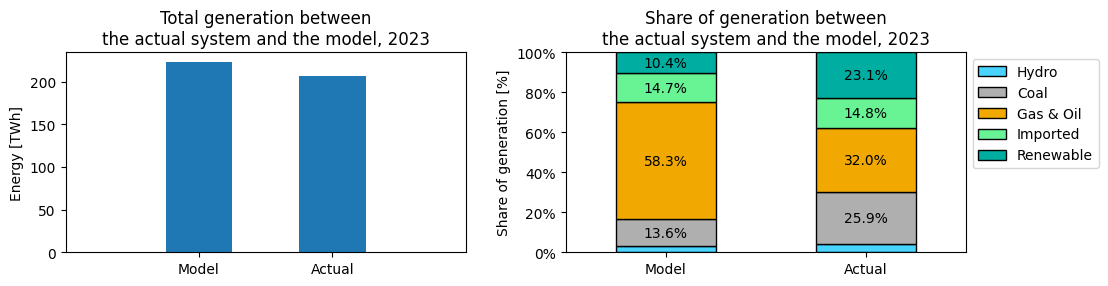

In [6]:
color = {
    'Hydro':'#49d3ff', 'Coal':'#afafaf', 'Gas & Oil':'#f1a800',
    'Imported':'#68f394', 'Renewable':'#00ada1', 'Storage': '#3e7ad3'
}
fig = plt.figure(figsize=(10, 5))
ax_share = fig.add_axes(rect=(0.6, 0.1, 0.4, 0.4))
gen = gen_by_fuel[['gen_actual', 'gen_model']]
gen_share = (gen / gen.sum(axis=0) * 100).T
gen_share.plot.bar(
    stacked=True, ax=ax_share, edgecolor='black', color=color
)
ax_share.set_title(
    'Share of generation between' +
    '\nthe actual system and the model, 2023'
)
ax_share.set_ylim(0,100)
ax_share.set_xticklabels(['Model', 'Actual'], rotation=0)
ax_share.set_yticks(ax_share.get_yticks(), [f'{x:.0f}%' for x in ax_share.get_yticks()])
ax_share.set_ylabel('Share of generation [%]')
legend = ax_share.get_legend()
legend.set_bbox_to_anchor((1, 1))

# Add annotations to the bars
for i in range(len(gen_share)):
    for j in range(len(gen_share.columns)):
        percentage = gen_share.iloc[i, j]
        if percentage > 5:  # Display only for percentages greater than 5%
            ax_share.text(
                x= ax_share.get_xticks()[i], 
                y= gen_share.iloc[i, :j].sum() + percentage / 2,
                s=f'{percentage:.1f}%',
                ha='center', va='center', fontsize=10
            )
ax_amount = fig.add_axes(rect=(0.1, 0.1, 0.4, 0.4))
ax_amount.set_title(
    'Total generation between' +
    '\nthe actual system and the model, 2023'
)
gen_amount = gen.sum(axis='index').to_frame().T / 1e3
ax_amount.bar(gen_amount.columns, gen_amount.iloc[0], width=0.5)
ax_amount.set_xticks(ax_amount.get_xticks(),['Model', 'Actual'], rotation=0)
ax_amount.set_ylabel('Energy [TWh]')
ax_amount.set_xlim(-1,2);

## Optimal power generation schedule

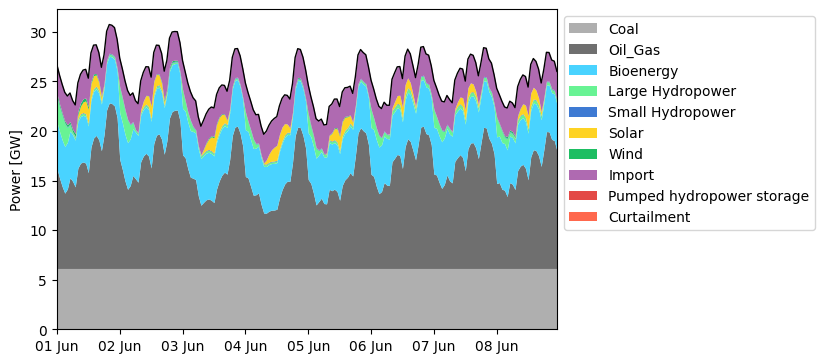

In [7]:
color = {
    'Bioenergy':'#49d3ff', 'Large Hydropower':'#68F394',
    'Small Hydropower':'#3E7AD3', 'Solar':'#FED324',
    'Wind':'#1DBE62', 'Pumped hydropower storage':'#E34946', 'Coal':'#AFAFAF',
    'Oil_Gas':'#6F6F6F', 'Import':'#AF6AB1',
    'Curtailment':'#FF684D', 'Total load':'#000000'
}
power = ds.gen.sum(dim=['zone', 'year', 'month']).to_dataframe().unstack()
power = power.droplevel(axis=1, level=0)
power['Curtailment'] = (
    power_renewable - power[capacity_factor.columns].sum(axis=1).values 
)
power.index = pd.date_range(start='2023-01-01', periods=8760, freq='H')
selected_power = power.loc['20230601':'20230608'] / 1e3
idx = selected_power.index
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes(rect=(0.1, 0.1, 0.5, 0.8))
ax.plot(load.loc[selected_power.index] / 1e3, color='black', lw=1)
selected_power.plot.area(lw=0, color=color, ax=ax)
ax.set_ylabel("Power [GW]", fontsize = 10)
ax.set_xlim(idx[0], idx[-1])
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))
legend.set_title(None)  # Remove the legend title
# Set date format for x-axis
ax.set_xticks(idx[::24], idx[::24], rotation=0, ha='center')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'));